# Traffic Signal Classifier

**Table to Contents**

- Step 1: Import all the dependencies
- Step 2: Load The Data
- Step 3: Dataset Summary & Exploration
    - Step 3.1: Visualization of the dataset
        - Step 3.1.1 Training dataset
        - Step 3.1.2 Validation dataset
        - Step 3.1.3 Test dataset
- Step 4: Architecture
    - Step 4.1: Data preprocessor
        - Step 4.1.2: Normalise data
    - Step 4.2: Model Architecture
        - Step 4.2.1: Training
- Step 5: Testing on New Data
    - Step 5.1 Images Used
        - Step 5.1.1: Data-1
        - Step 5.1.2: Data-2
        - Step 5.1.3: Data-3
        - Step 5.1.4: Data-4
        - Step 5.1.5: Data-5
    - Step 5.2: Prediction
    - Step 5.3: Top 5 Softmax Probabilities
        - Step 5.3.1: Certainty for "No Entry"
        - Step 5.3.2: Certainty for "10 KM"
        - Step 5.3.3: Certainty for "Wrong Way"
        - Step 5.3.4: Certainty for "Give Way"
        - Step 5.3.5: Certainty for "Stop"
- Step 6: Visualize the Neural Network's State with Test Images
- Step 7: Question
    - Question 7.1: Describe your training model.
    - Question 7.2: How did you finalise the hyperparameters?

---
## Step 1: Import all the dependencies

In [23]:
import pickle
import random
import sys

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

## Step 2: Load The Data

Loading the pickled files.

In [3]:
TRAINING_FILE = 'train.p'
VALIDATION_FILE = 'valid.p'
TESTING_FILE = 'test.p'

with open(TRAINING_FILE, mode='rb') as f:
    train = pickle.load(f)
with open(VALIDATION_FILE, mode='rb') as f:
    valid = pickle.load(f)
with open(TESTING_FILE, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 3: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

In [28]:
# Prints the description of the dataset.

n_train = len(X_train)
n_test = len(X_test)
n_validation = len(X_validation)

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()
image_shape = np.shape(image)

n_classes = len(set(y_train))

print("Number of training samples =", n_train)
print("Number of testing samples =", n_test)
print("Number of validation samples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training samples = 34799
Number of testing samples = 12630
Number of validation samples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


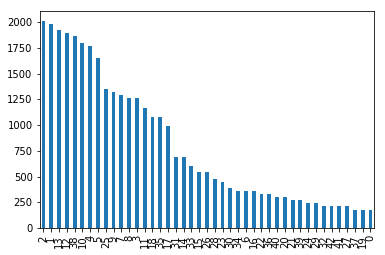

In [27]:
# Histogram for number of samples of each sign in the training set

count = pd.Series(y_train).value_counts()

count.plot.bar()

plt.show()

### Step 3.1: Visualization of the dataset

In [62]:
def show_image(data):
    """
    Displays a random images from the dataset with the class label.
    """
    num = 1
    index = random.sample(range(len(data)), 4)

    fig = plt.figure()

    for n in index:
        fig.add_subplot(2, 2, num)
        image = data[n].squeeze()
        plt.imshow(image)
        plt.title("Class Label {}".format(n))
        num += 1
        
    fig.tight_layout()
    plt.show()
    %matplotlib inline

#### Step 3.1.1 Training dataset

Displaying random training data.

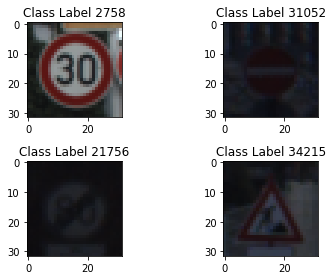

In [63]:
show_image(X_train)

#### Step 3.1.2 Validation dataset

Displaying random validation data.

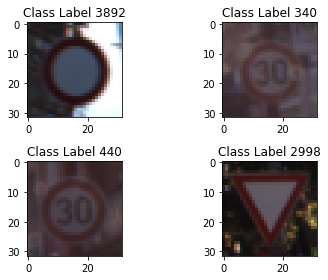

In [64]:
show_image(X_validation)

#### Step 3.1.3 Test dataset

Displaying random test data.

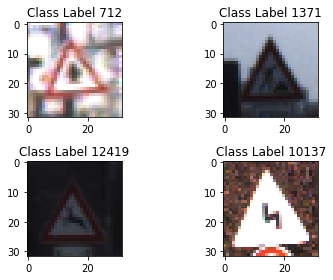

In [65]:
show_image(X_test)

----

## Step 4: Architecture

Using the LeNet architecture

![LeNet](images/lenet.png)

### Step 4.1: Data preprocessor

Before training the dataset, the date needs to be preprocessed just to make the computation faster.

So the first step is to normalise the date, I haven't taken the step to grayscale the data. I think the colour makes an important feature in case of signs because what if the signs are inverted and somehow colour could be an import way to recognise the sign.

#### Step 4.1.2: Normalise data

Using the formula:

\begin{equation*}
y_i=\frac{x_i-\mu(x)}{\max(x)-\min(x)}
\end{equation*}

In [66]:
X_train = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_validation = (X_validation - X_validation.mean()) / (np.max(X_validation) - np.min(X_validation))
X_test = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))

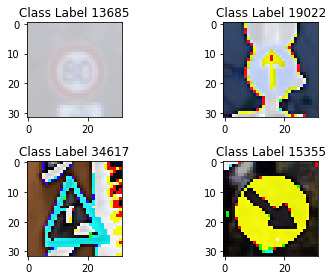

In [67]:
show_image(X_train)

### Step 4.2: Model Architecture

Using two layer Convolutional Neural Network and three fully connected layers, the code is written. This code trains, validates and tests the input data.

#### Step 4.2.1: Training

In [68]:
EPOCHS = 100
BATCH_SIZE = 100
RATE = 0.001
MU = 0
SIGMA = 0.1
PADDING = 'VALID'

In [76]:
# Shuffle the data
X_train, y_train = shuffle(X_train, y_train)

In [77]:
def lenet(x_input):
    """
    CNN for the dataset.
    Parameters
    ----------
    x_input

    Returns
    -------
    tensor
    """
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean=MU, stddev=SIGMA))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x_input, conv1_w, strides=[1, 1, 1, 1], padding=PADDING) + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding=PADDING)

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean=MU, stddev=SIGMA))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides=[1, 1, 1, 1], padding=PADDING) + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape=(400, 120), mean=MU, stddev=SIGMA))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b

    # Activation.
    fc1 = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape=(120, 84), mean=MU, stddev=SIGMA))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b

    # Activation.
    fc2 = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_w = tf.Variable(tf.truncated_normal(shape=(84, 43), mean=MU, stddev=SIGMA))
    fc3_b = tf.Variable(tf.zeros(43))
    _logits = tf.matmul(fc2, fc3_w) + fc3_b

    return _logits

In [78]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [79]:
# Get the model
logits = lenet(x)

# loss and optimizer
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=RATE)
training_operation = optimizer.minimize(loss_operation)

# Check if correctly predicted.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [80]:
def evaluate(X_data, y_data):
    """
    Evaluates the total accuracy for the given inputs.
    Parameters
    ----------
    X_data
    y_data

    Returns
    -------
    numpy.float64

    """
    num_examples = len(X_data)
    total_accuracy = 0
    with sess.as_default():
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [81]:
# Running the training
sess = tf.Session()
sess.run(tf.global_variables_initializer())
num_examples = len(X_train)
validation_accuracy = 0

print("Training...")
print()
for i in range(EPOCHS):
    if validation_accuracy >= 0.95:
        break
    _X_train, _y_train = shuffle(X_train, y_train)
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = _X_train[offset:end], _y_train[offset:end]
        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
    
    
    validation_accuracy = evaluate(X_validation, y_validation)
    test_accuracy = evaluate(X_test, y_test)
    print("EPOCH {} ...".format(i + 1))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
saver.save(sess, './lenet')
print("Model saved")

print()
print()

print("Batch size: ", BATCH_SIZE)
print("Number of epochs: ", EPOCHS)
print("Learning rate: ", RATE)
print("Mean for Truncated Normal: ", MU)
print("Standard devation for Truncated Normal: ", SIGMA)
print("Convolution type: ", PADDING)

Training...

EPOCH 1 ...
Test Accuracy = 0.716
Validation Accuracy = 0.730
EPOCH 2 ...
Test Accuracy = 0.823
Validation Accuracy = 0.842
EPOCH 3 ...
Test Accuracy = 0.842
Validation Accuracy = 0.854
EPOCH 4 ...
Test Accuracy = 0.870
Validation Accuracy = 0.875
EPOCH 5 ...
Test Accuracy = 0.873
Validation Accuracy = 0.887
EPOCH 6 ...
Test Accuracy = 0.886
Validation Accuracy = 0.892
EPOCH 7 ...
Test Accuracy = 0.891
Validation Accuracy = 0.904
EPOCH 8 ...
Test Accuracy = 0.891
Validation Accuracy = 0.894
EPOCH 9 ...
Test Accuracy = 0.896
Validation Accuracy = 0.906
EPOCH 10 ...
Test Accuracy = 0.893
Validation Accuracy = 0.905
EPOCH 11 ...
Test Accuracy = 0.893
Validation Accuracy = 0.908
EPOCH 12 ...
Test Accuracy = 0.888
Validation Accuracy = 0.907
EPOCH 13 ...
Test Accuracy = 0.902
Validation Accuracy = 0.917
EPOCH 14 ...
Test Accuracy = 0.910
Validation Accuracy = 0.921
EPOCH 15 ...
Test Accuracy = 0.895
Validation Accuracy = 0.903
EPOCH 16 ...
Test Accuracy = 0.901
Validation Accur

## Step 5: Testing on New Data

Once the model is trained, tested and validated with good results, it's time to predict new (unknown) traffic signs.

In [51]:
from PIL import Image, ImageStat

def load_image(file_name):
    """
    Loads and converts the image into an NumPy array.
    """
    try:
        image = mpimg.imread(file_name)  # Reading a image file.
        print("Image type: {}, and it's shape: {}".format(type(image), image.shape))
    except FileNotFoundError as e:
        print(e)
        sys.exit(1)
    return image


def show_image_test(image):
    plt.figure()
    plt.imshow(image)
    plt.show()

def get_more_info(path):
    img = Image.open(path)
    width, height = img.size
    
    # Brightness
    im = img.convert('L')
    stat = ImageStat.Stat(im)
    
    print("Height: {} and Width: {}".format(width, height))
    print("Brightness: ", stat.mean[0])
    print("Mode: ", img.mode)
    print("Contrast: ", stat.rms[0])

### Step 5.1 Images Used

For this experiment, I have used five traffic signs.

#### Step 5.1.1: Data-1

No entry sign.

Image type: <class 'numpy.ndarray'>, and it's shape: (425, 425, 3)
Height: 425 and Width: 425
Brightness:  157.91422560553633
Mode:  RGB
Contrast:  177.98636823506638


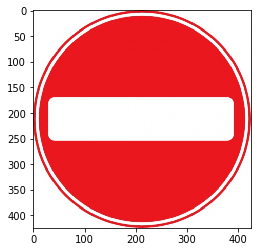

In [53]:
im1_l = 'images/no_entry.jpg'
im1 = load_image(im1_l)
get_more_info(im1_l)
show_image_test(im1)

#### Step 5.1.2: Data-2

10 speed limit.

Image type: <class 'numpy.ndarray'>, and it's shape: (225, 300, 3)
Height: 300 and Width: 225
Brightness:  127.69592592592592
Mode:  RGB
Contrast:  145.30666763524397


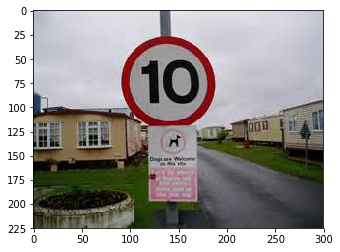

In [55]:
im2_l = 'images/10.jpg'
im2 = load_image(im2_l)
get_more_info(im2_l)
show_image_test(im2)

#### Step 5.1.3: Data-3

Wrong way sign

Image type: <class 'numpy.ndarray'>, and it's shape: (200, 300, 3)
Height: 300 and Width: 225
Brightness:  127.69592592592592
Mode:  RGB
Contrast:  145.30666763524397


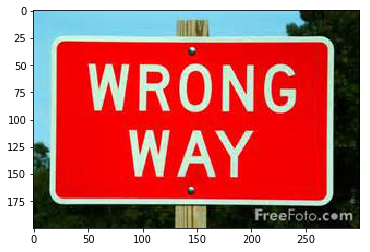

In [56]:
im3_l = 'images/wrong_way.jpg'
im3 = load_image(im3_l)
get_more_info(im2_l)
show_image_test(im3)

#### Step 5.1.4: Data-4

Give way sign.

Image type: <class 'numpy.ndarray'>, and it's shape: (225, 300, 3)
Height: 300 and Width: 225
Brightness:  93.52752592592593
Mode:  RGB
Contrast:  110.50265168596466


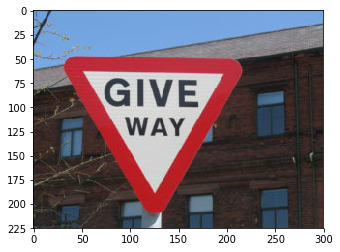

In [57]:
im4_l = 'images/give_way_sign.jpg'
im4 = load_image(im4_l)
get_more_info(im4_l)
show_image_test(im4)

#### Step 5.1.5: Data-5

Stop sign.

Image type: <class 'numpy.ndarray'>, and it's shape: (493, 876, 3)
Height: 876 and Width: 493
Brightness:  155.05880268971075
Mode:  RGB
Contrast:  167.9383344340375


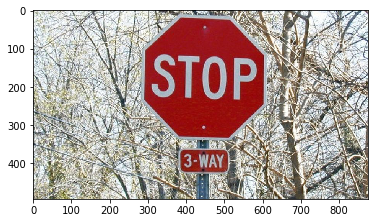

In [58]:
im5_l = 'images/stop.jpg'
im5 = load_image(im5_l)
get_more_info(im5_l)
show_image_test(im5)

### Step 5.2 Images Manipulation

The dataset used to train the model is of size `(32, 32, 3)`, i.e. `32` pixels by `32` pixels with three layers of Red, Green and Blue colors. So the new data nees to be cropped and rescaled to the dimentions specified in `x = tf.placeholder(tf.float32, (None, 32, 32, 3))`

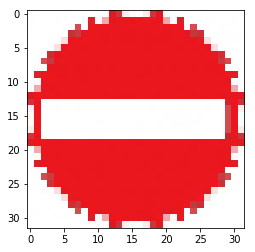

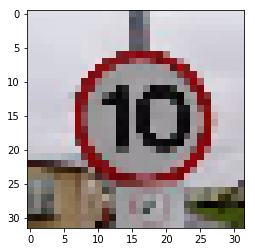

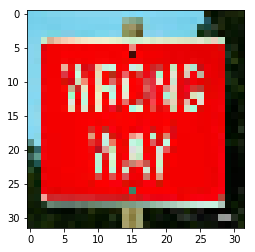

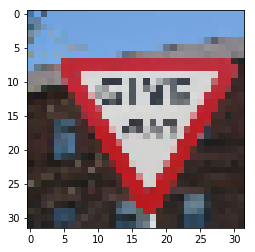

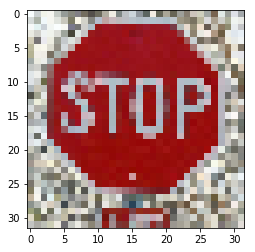

In [91]:
im1_scaled = cv2.resize(im1, (32, 32))
show_image_test(im1_scaled)

im2_cropped = im2[0:150, 60:210, :]
im2_scaled = cv2.resize(im2_cropped, (32, 32))
show_image_test(im2_scaled)

im3_scaled = cv2.resize(im3, (32, 32))
show_image_test(im3_scaled)

im4_cropped = im4[:, 0:225, :]
im4_scaled = cv2.resize(im4_cropped, (32, 32))
show_image_test(im4_scaled)

im5_cropped = im5[0:400, 250:650, :]
im5_scaled = cv2.resize(im5_cropped, (32, 32))
show_image_test(im5_scaled)



### Step 5.2: Prediction

Predicting the new data with the trained model.

In [92]:
def show_pred_image(index):
    """
    Plot the index of the prediced value.
    """
    plt.imshow(X_train[index])

In [93]:
def prediction(data):
    """
    Reload the saved model and predict the input data.
    """
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        classification = sess.run(tf.argmax(logits, 1), feed_dict={x: [data]})
#         classification = sess.run(accuracy_operation, feed_dict={x: data, y: 1})
        print(classification)
    return classification

[17]


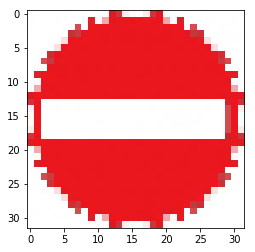

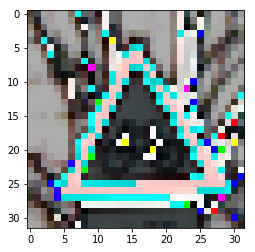

In [94]:
pred1 = prediction(im1_scaled)
show_image_test(im1_scaled)
show_pred_image(pred1[0])

[1]


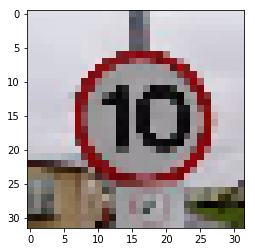

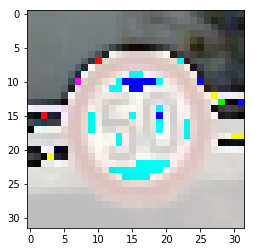

In [95]:
pred2 = prediction(im2_scaled)
show_image_test(im2_scaled)
show_pred_image(pred2[0])

[14]


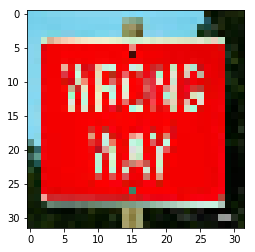

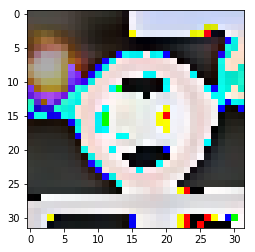

In [96]:
pred3 = prediction(im3_scaled)
show_image_test(im3_scaled)
show_pred_image(pred3[0])

[13]


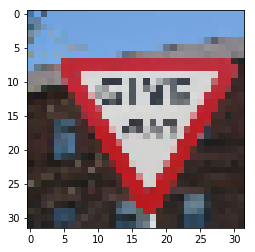

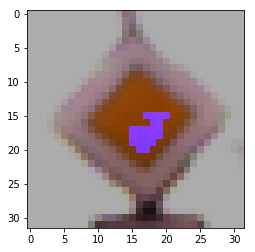

In [97]:
pred4 = prediction(im4_scaled)
show_image_test(im4_scaled)
show_pred_image(pred4[0])

[14]


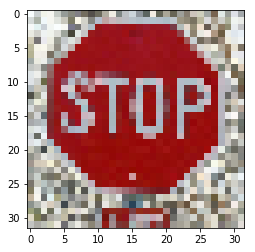

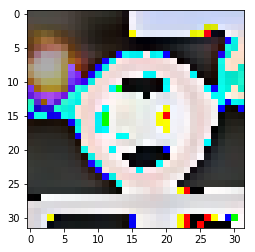

In [98]:
pred5 = prediction(im5_scaled)
show_image_test(im5_scaled)
show_pred_image(pred5[0])

### Step 5.3: Top 5 Softmax Probabilities

The orginal code does not use SoftMax as is, so the following code gets the SoftMax for the new image given to it.

In [130]:
def get_softmax(img):
    """
    Get the top 5 SoftMax probability.
    """
    softmax = tf.nn.softmax(logits=logits)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        output = sess.run(softmax, feed_dict={x: [img]})
        out = sess.run(tf.nn.top_k(tf.constant(output), k=5))
        print(out)
        return out

def read_signs_csv():
    """
    Read the csv file.
    """
    return pd.read_csv('signnames.csv', delimiter=",")

def plot_max(probabilities, labels):
    """
    Plot bar chart.
    """
    y_pos = np.arange(len(labels))
#     performance = [10,8,6,4,2,1]

    plt.bar(y_pos, probabilities, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel('Probability')
    plt.xlabel('Traffic sign')
    plt.title('Model\'s certainty of its predictions')
    
    l = read_signs_csv()

    plt.show()
    print("Traffic Sign Key")
    for label in labels:
        print(label, ": ", l.loc[label]['SignName'])

#### Step 5.3.1: Certainty for "No Entry"

TopKV2(values=array([[  1.00000000e+00,   1.09075001e-13,   4.11398972e-17,
          9.08250193e-20,   6.59110850e-33]], dtype=float32), indices=array([[13, 36, 20,  5, 30]]))


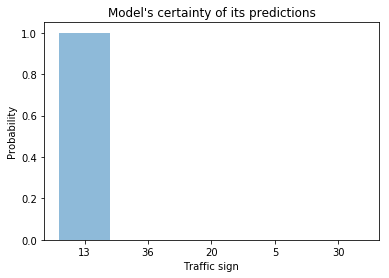

Traffic Sign Key
13 :  Yield
36 :  Go straight or right
20 :  Dangerous curve to the right
5 :  Speed limit (80km/h)
30 :  Beware of ice/snow


In [131]:
i1 = get_softmax(im1_scaled)
plot_max(i1[0][0], i1[1][0])

#### Step 5.3.2: Certainty for "10 KM"

TopKV2(values=array([[  6.81911826e-01,   3.08255285e-01,   8.88243970e-03,
          9.34019103e-04,   1.05868412e-05]], dtype=float32), indices=array([[16, 27, 34,  6, 19]]))


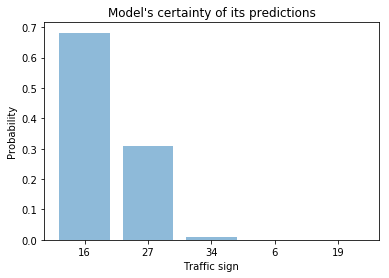

Traffic Sign Key
16 :  Vehicles over 3.5 metric tons prohibited
27 :  Pedestrians
34 :  Turn left ahead
6 :  End of speed limit (80km/h)
19 :  Dangerous curve to the left


In [132]:
i2 = get_softmax(im2_scaled)
plot_max(i2[0][0], i2[1][0])

#### Step 5.3.3: Certainty for "Wrong Way"

TopKV2(values=array([[  1.00000000e+00,   6.75178446e-12,   3.93871581e-20,
          6.47886413e-23,   5.13253810e-24]], dtype=float32), indices=array([[ 1, 30, 16, 41, 24]]))


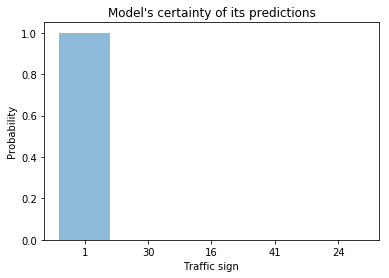

Traffic Sign Key
1 :  Speed limit (30km/h)
30 :  Beware of ice/snow
16 :  Vehicles over 3.5 metric tons prohibited
41 :  End of no passing
24 :  Road narrows on the right


In [133]:
i3 = get_softmax(im3_scaled)
plot_max(i3[0][0], i3[1][0])

#### Step 5.3.4: Certainty for "Give Way"

TopKV2(values=array([[  1.00000000e+00,   2.10788174e-19,   2.79429676e-37,
          1.16835081e-39,   1.23674399e-40]], dtype=float32), indices=array([[30,  4, 27, 19,  8]]))


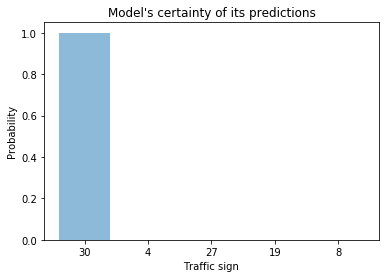

Traffic Sign Key
30 :  Beware of ice/snow
4 :  Speed limit (70km/h)
27 :  Pedestrians
19 :  Dangerous curve to the left
8 :  Speed limit (120km/h)


In [134]:
i4 = get_softmax(im4_scaled)
plot_max(i4[0][0], i4[1][0])

#### Step 5.3.5: Certainty for "Stop"

TopKV2(values=array([[  1.00000000e+00,   6.08752482e-27,   3.78068770e-31,
          1.60917595e-32,   2.33601539e-36]], dtype=float32), indices=array([[23, 31, 42,  6, 17]]))


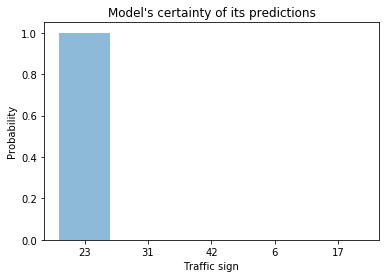

Traffic Sign Key
23 :  Slippery road
31 :  Wild animals crossing
42 :  End of no passing by vehicles over 3.5 metric tons
6 :  End of speed limit (80km/h)
17 :  No entry


In [135]:
i5 = get_softmax(im5_scaled)
plot_max(i5[0][0], i5[1][0])

---

## Step 6: Visualize the Neural Network's State with Test Images

As we are using only three CNN layers, the output is three images that are displayed below.

In [127]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = tf_activation.eval(session=sess,feed_dict={x : [image_input]})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

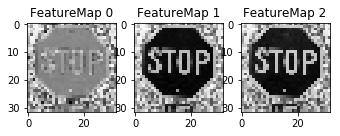

In [128]:
with tf.Session() as sess:
    hidden_layer = tf.nn.relu(x)
    outputFeatureMap(im5_scaled, hidden_layer, plt_num=1)

---

## Step 7: Questions

### Question 7.1: Describe your training model.

**Answer**

| Layers            | Inputs and Outputs                   | Computation                                                                                                                                                                                                                                                                                                  |
|-------------------|--------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Convolution 1     | Inputs: 32x32x1<br> Output: 28x28x6  | **Truncated Normal** <br> Mean: 0<br> Standard Devation: 0.1<br> Shape: (5, 5, 3, 6)<br><br> **2D Convolutions**<br> strides: [1, 1, 1, 1]<br> padding: VALID<br><br> **ReLU Activation**<br><br> **Max Pooling**<br> padding: VALID<br> ksize: [1, 2, 2, 1]<br> strides: [1, 2, 2, 1]<br> padding: VALID    |
| Convolution 2     | Inputs: 14x14x6<br> Output: 10x10x16 | **Truncated Normal**<br><br> Mean: 0<br> Standard Devation: 0.1<br> Shape: (5, 5, 3, 6)<br><br> **2D Convolutions**<br> strides: [1, 1, 1, 1]<br> padding: VALID<br><br> **ReLU Activation**<br><br> **Max Pooling**<br> padding: VALID<br> ksize: [1, 2, 2, 1]<br> strides: [1, 2, 2, 1]<br> padding: VALID |
| Flatten (Reshape) | Input: 10x10x16<br> Output: 400      |                                                                                                                                                                                                                                                                                                              |
| Fully Connected 1 | Input: 400<br> Output: 120           | **Truncated Normal**<br> shape: (400, 120)<br> mean: 0<br> sigma: 0.1<br><br>  **WX+B**<br><br>  **ReLU Activation**                                                                                                                                                                                         |
| Fully Connected 2 | Input: 120<br> Output: 84            | **Truncated Normal**<br> shape: (120, 84)<br> mean: 0<br> sigma: 0.1<br><br> **WX+B**<br><br> **ReLU Activation**                                                                                                                                                                                            |
| Output            | Input: 84<br> Output:43              | **Truncated Normal**<br> shape: (84, 43)<br> mean: 0<br> sigma: 0.1<br><br> **WX+B**<br><br> **ReLU Activation**                                                                                                                                                                                             |

### Question 7.2: How did you finalise the hyperparameters?

**Answer**

I have done 200 experiments changing the BATCH number from 1 to 200, and RATE from 0.01 to 0.001 (randomly). The results are as follows:

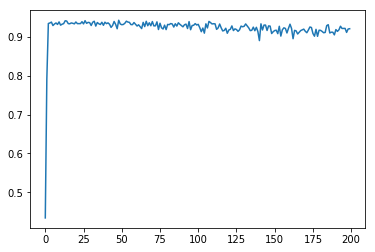

In [129]:
import os
import re

def atoi(text):
    """
    Checks if the file names contain numbers.
    Parameters
    ----------
    text
        This parameter could be a str or int.
    Returns
    -------
    flow  :  int, str
    """
    flow = int(text) if text.isdigit() else text
    return flow


def natural_keys(text):
    """
    Splits the number from the file name.
    Parameters
    ----------
    text
        A str parameter with number should be give, so the this method could split the contents.
    Returns
    -------
    flow  :  list
        List of strings.
    """
    flow = [atoi(c) for c in re.split('(\d+)', text)]
    return flow

file_names = [filename for filename in os.listdir("log/1/") if filename.startswith("val")]
file_names.sort(key=natural_keys)

data = []

for names in file_names:
    data.append(np.mean(np.genfromtxt('log/1/' + names,delimiter=',')))

plt.plot(data)
plt.show()

Looking at the graph, the batch size between 100 to 105 seems to be a controlled state, anything after that looks to fluctuating a lot.